In [1]:
# import required libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr, pearsonr, f_oneway, chi2_contingency, zscore

In [2]:
# read data into a df
csv_file = "alzheimers_disease_data.csv"
data = pd.read_csv(csv_file)
data.head()


,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,DoctorInCharge
0,4751,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,...,0,0,1.725883,0,0,0,1,0,0,XXXConfid
1,4752,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,...,0,0,2.592424,0,0,0,0,1,0,XXXConfid
2,4753,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,...,0,0,7.119548,0,1,0,1,0,0,XXXConfid
3,4754,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,...,0,1,6.481226,0,0,0,0,0,0,XXXConfid
4,4755,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,...,0,0,0.014691,0,0,1,1,0,0,XXXConfid


## Data Cleaning, Analysis, and Visualization

In [3]:
# remove irrelavent columns for analysis 
data.columns
data = data.drop(columns=['DoctorInCharge'])

In [4]:
# check for missing values before analysis 
missing_values = data.isnull().sum()
missing_values

PatientID                    0
Age                          0
Gender                       0
Ethnicity                    0
EducationLevel               0
BMI                          0
Smoking                      0
AlcoholConsumption           0
PhysicalActivity             0
DietQuality                  0
SleepQuality                 0
FamilyHistoryAlzheimers      0
CardiovascularDisease        0
Diabetes                     0
Depression                   0
HeadInjury                   0
Hypertension                 0
SystolicBP                   0
DiastolicBP                  0
CholesterolTotal             0
CholesterolLDL               0
CholesterolHDL               0
CholesterolTriglycerides     0
MMSE                         0
FunctionalAssessment         0
MemoryComplaints             0
BehavioralProblems           0
ADL                          0
Confusion                    0
Disorientation               0
PersonalityChanges           0
DifficultyCompletingTasks    0
Forgetfu

In [5]:
# check for duplicates before analysis
duplicates = data.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


In [6]:
# check for outliers in numerical columns before analysis
columns_to_check = [
    'BMI', 'CholesterolTotal', 'SystolicBP', 'DiastolicBP',
    'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides',
    'MMSE', 'FunctionalAssessment'
]
outlier_counts = {}
for column in columns_to_check:
    z_scores = zscore(data[column].dropna())  
    outliers = (abs(z_scores) > 3)
    outlier_counts[column] = outliers.sum()
outlier_summary = pd.DataFrame({
    'Column': outlier_counts.keys(),
    'Number of Outliers': outlier_counts.values()
})
outlier_summary.loc['Total'] = ['Total', outlier_summary['Number of Outliers'].sum()]
outlier_summary


,Column,Number of Outliers
0,BMI,0
1,CholesterolTotal,0
2,SystolicBP,0
3,DiastolicBP,0
4,CholesterolLDL,0
5,CholesterolHDL,0
6,CholesterolTriglycerides,0
7,MMSE,0
8,FunctionalAssessment,0
Total,Total,0


In [7]:
# check if there is a high correlation between columns excluding diagnosis
# account for the difference in column types (binary, categorical, and continous)
binary_columns = [col for col in data.columns if data[col].nunique() == 2 and col not in ['Diagnosis', 'PatientID']]
continuous_columns = [col for col in data.columns if col not in binary_columns and col not in ['Diagnosis', 'PatientID', 'Ethnicity', 'EducationLevel']]
categorical_columns = ['Ethnicity', 'EducationLevel']
def cramers_v(x, y):
    contingency_table = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    return np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))
correlation_results = []
columns_to_check = [col for col in data.columns if col not in ['Diagnosis', 'PatientID']]
for i, col1 in enumerate(columns_to_check):
    for col2 in columns_to_check[i + 1:]:  
        if col1 == col2:
            continue
        if col1 in continuous_columns and col2 in continuous_columns:
            corr, _ = pearsonr(data[col1].dropna(), data[col2].dropna())
            method = 'Pearson'
        elif (col1 in binary_columns and col2 in continuous_columns) or (col2 in binary_columns and col1 in continuous_columns):
            binary_col = col1 if col1 in binary_columns else col2
            continuous_col = col1 if col1 in continuous_columns else col2
            corr, _ = pointbiserialr(data[binary_col].dropna(), data[continuous_col].dropna())
            method = 'Point-Biserial'
        elif (col1 in binary_columns or col1 in categorical_columns) and (col2 in binary_columns or col2 in categorical_columns):
            corr = cramers_v(data[col1], data[col2])
            method = 'Cramér\'s V'
        elif (col1 in categorical_columns and col2 in continuous_columns) or (col2 in categorical_columns and col1 in continuous_columns):
            categorical_col = col1 if col1 in categorical_columns else col2
            continuous_col = col1 if col1 in continuous_columns else col2
            groups = [data[continuous_col][data[categorical_col] == level] for level in data[categorical_col].unique()]
            f_stat, _ = f_oneway(*groups)
            corr = f_stat / (f_stat + len(data))  
            method = 'Normalized F-stat'
        else:
            continue
        if -1 <= corr <= 1: 
            correlation_results.append({'Feature1': col1, 'Feature2': col2, 'Correlation': corr})
        else:
            print(f"Invalid correlation detected: {col1} vs {col2} - {corr}")
correlation_df = pd.DataFrame(correlation_results)
correlation_df.sort_values(by='Correlation', ascending=False, inplace=True)
correlation_df

,Feature1,Feature2,Correlation
101,EducationLevel,Hypertension,0.073077
88,Ethnicity,DifficultyCompletingTasks,0.072304
144,BMI,Forgetfulness,0.071131
63,Ethnicity,Smoking,0.063074
113,EducationLevel,Confusion,0.056687
...,...,...,...
361,Hypertension,DiastolicBP,-0.043424
226,DietQuality,Hypertension,-0.043628
291,CardiovascularDisease,DiastolicBP,-0.043662
314,Diabetes,CholesterolTriglycerides,-0.044906


In [8]:
# redundancy analysis (use correlation to identify highly correlated columns (>0.7) and remove to avoid collinearity)
correlation_matrix = data.drop(columns=['Diagnosis']).corr()
threshold = 0.7
high_corr_pairs = correlation_matrix.abs().where(lambda x: x > threshold).stack().reset_index()
high_corr_pairs = high_corr_pairs[high_corr_pairs['level_0'] < high_corr_pairs['level_1']]
high_corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']
print("Highly Correlated Feature Pairs:")
high_corr_pairs


Highly Correlated Feature Pairs:


,Feature1,Feature2,Correlation


/tmp/ipykernel_2468935/3891818862.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_count = data.groupby('AgeGroup')['Diagnosis'].count()


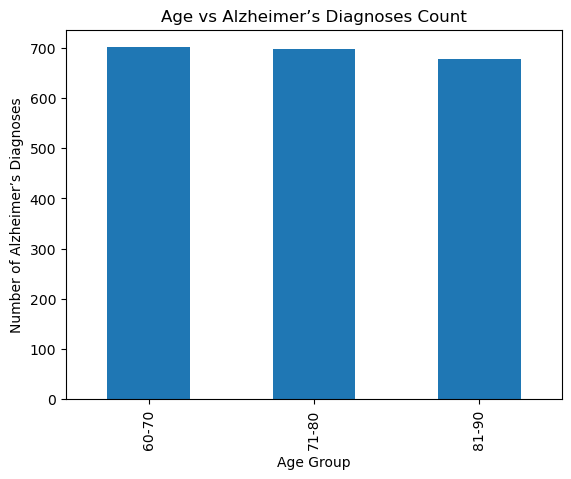

In [9]:
# Which age group is most at risk for Alzheimer's?
data['AgeGroup'] = pd.cut(data['Age'], bins=[60, 70, 80, 90], labels=["60-70", "71-80", "81-90"])
age_count = data.groupby('AgeGroup')['Diagnosis'].count()
age_count.plot(kind='bar', xlabel='Age Group', ylabel='Number of Alzheimer’s Diagnoses', title='Age vs Alzheimer’s Diagnoses Count')
plt.show()

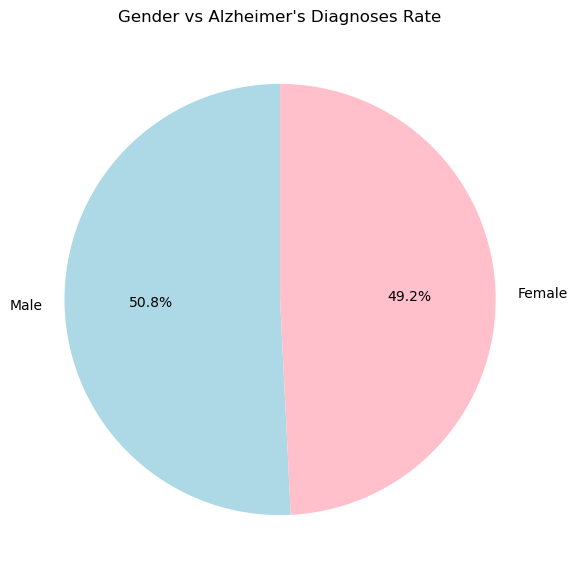

In [10]:
# Which gender is most at-risk for Alzheimer's?
gender_alzheimers = data[data['Diagnosis'] == 1]['Gender'].value_counts()
labels = ['Male', 'Female']
plt.figure(figsize=(7, 7))
plt.pie(gender_alzheimers, labels=labels, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'pink'])
plt.title('Gender vs Alzheimer\'s Diagnoses Rate')
plt.show()

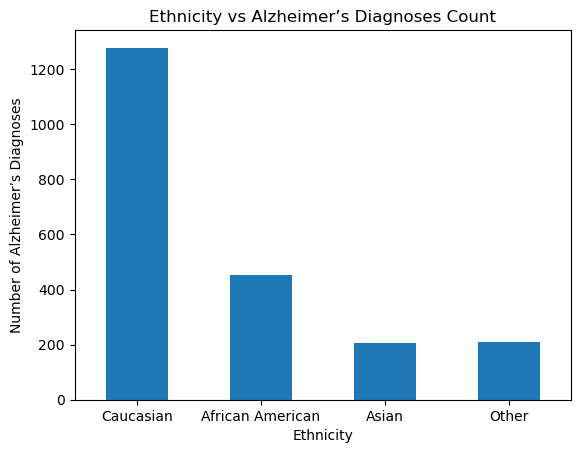

In [11]:
# Which ethnicity is most prone to Alzheimer's?
ethnicity_count = data.groupby('Ethnicity')['Diagnosis'].count()
ethnicity_count.plot(kind='bar', xlabel='Ethnicity', ylabel='Number of Alzheimer’s Diagnoses', title='Ethnicity vs Alzheimer’s Diagnoses Count')
plt.xticks(ticks=range(4), labels=['Caucasian', 'African American', 'Asian', 'Other'], rotation=0)
plt.show()

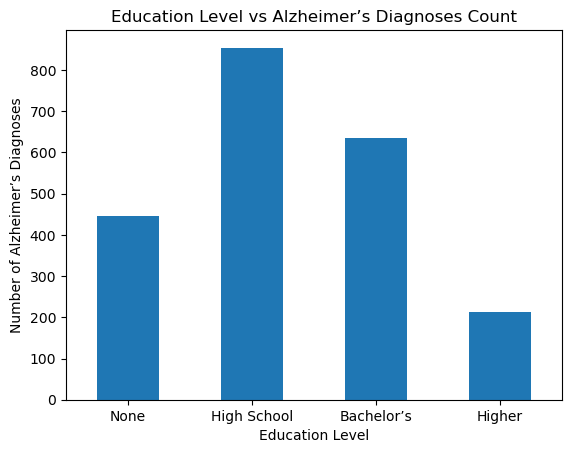

In [12]:
# Assuming that a higher education level means more stress experienced, 
# does educational stress increase the likelihood of being diagnosed with Alzheimers? 
edu_count = data.groupby('EducationLevel')['Diagnosis'].count()
edu_count.plot(kind='bar', xlabel='Education Level', ylabel='Number of Alzheimer’s Diagnoses', title='Education Level vs Alzheimer’s Diagnoses Count')
plt.xticks(ticks=range(4), labels=['None', 'High School', 'Bachelor’s', 'Higher'], rotation=0)
plt.show()


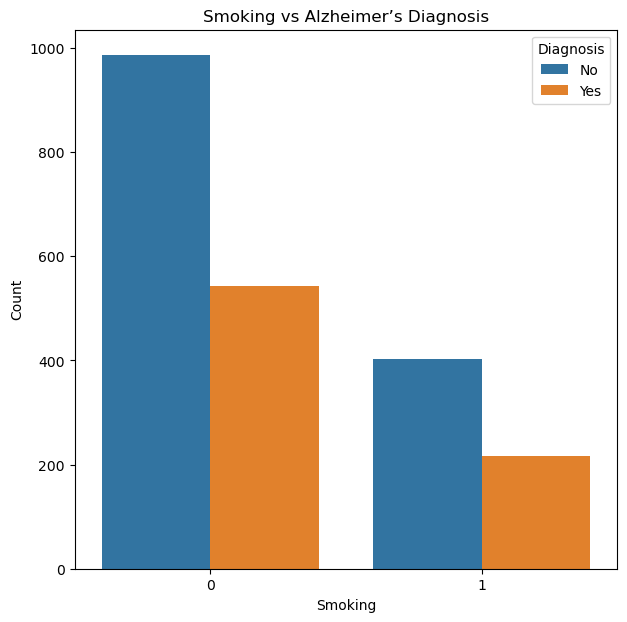

In [13]:
# How do smoking and alchol habits affect an Alzheimer's Diagnosis? 
fig, ax = plt.subplots(figsize=(7, 7))
sns.countplot(x='Smoking', hue='Diagnosis', data=data, ax=ax)
ax.set_title('Smoking vs Alzheimer’s Diagnosis')
ax.set_xlabel('Smoking')
ax.set_ylabel('Count')
ax.legend(title='Diagnosis', labels=['No', 'Yes'])
plt.show()


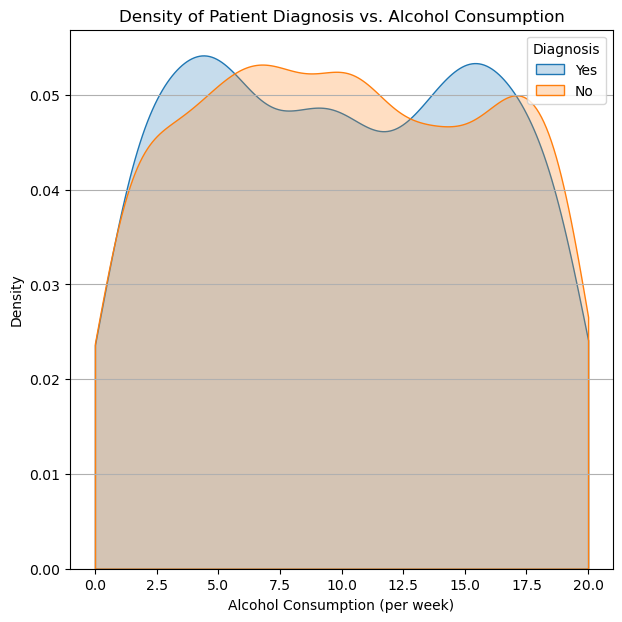

In [14]:
plt.figure(figsize=(7, 7))
sns.kdeplot(
    data=data[data['Diagnosis'] == 1], 
    x='AlcoholConsumption', 
    fill=True, 
    label="Yes",
    clip=(0, 20)
)
sns.kdeplot(
    data=data[data['Diagnosis'] == 0], 
    x='AlcoholConsumption', 
    fill=True, 
    label="No",
    clip=(0, 20)
)
plt.title('Density of Patient Diagnosis vs. Alcohol Consumption')
plt.xlabel('Alcohol Consumption (per week)')
plt.ylabel('Density')
plt.legend(title='Diagnosis')
plt.grid(axis='y')
plt.show()

In [ ]:
sns.displot(
    data=data,
    x='AlcoholConsumption',
    hue='Diagnosis',
    col='Smoking',
    kind='kde',
    fill=True,
    clip=(0, 20) 
)
plt.subplots_adjust(top=0.85)
plt.suptitle("Effects of Alcohol and Smoking on Diagnosis Density")
plt.show()

In [ ]:
# How does physical activity, diet quality, and sleep quality impact an Alzheimer's Diagnosis?
sns.displot(
    data=data,
    x='PhysicalActivity',
    hue='Diagnosis',
    kind='kde',
    fill=True,
    clip=(0, data['PhysicalActivity'].max())
)
plt.title("Physical Activity vs Diagnosis Density")
sns.displot(
    data=data,
    x='DietQuality',
    hue='Diagnosis',
    kind='kde',
    fill=True,
    clip=(0, data['DietQuality'].max())
)
plt.title("Diet Quality vs Diagnosis Density")
sns.displot(
    data=data,
    x='SleepQuality',
    hue='Diagnosis',
    kind='kde',
    fill=True,
    clip=(0, data['SleepQuality'].max()) 
)
plt.title("Sleep Quality vs Diagnosis Density")
plt.show()

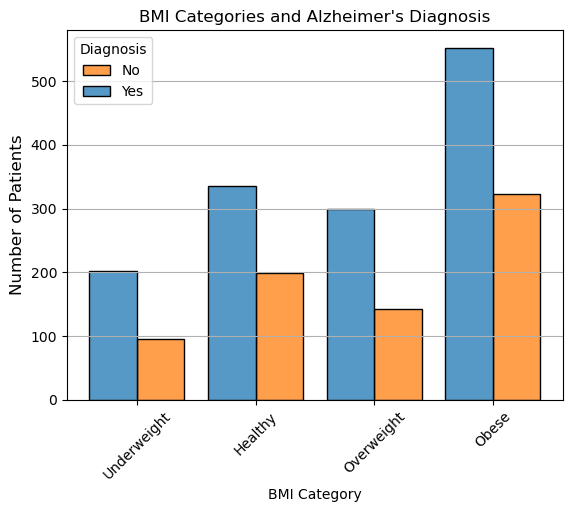

In [17]:
# How does BMI affect likelihood of Alzheimer's?
bins = [0, 18.5, 24.9, 29.9, 40]
labels = ['Underweight', 'Healthy', 'Overweight', 'Obese']  
data['BMI Category'] = pd.cut(data['BMI'], bins=bins, labels=labels)
sns.histplot(
    data=data,
    x='BMI Category',
    hue='Diagnosis',
    multiple='dodge',
    shrink=0.8,
)
plt.title('BMI Categories and Alzheimer\'s Diagnosis')
plt.xlabel('BMI Category')
plt.ylabel('Number of Patients', fontsize=12)
plt.legend(title='Diagnosis', labels=['No', 'Yes'])
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

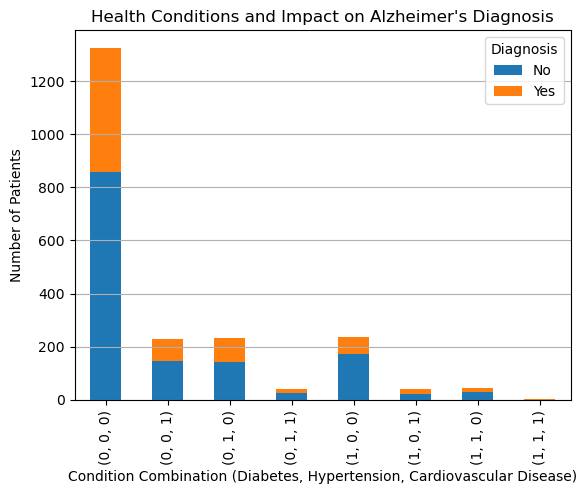

In [18]:
# How do health conditions increase the risk of Alzheimer's?
stacked_data = data.groupby(['Diabetes', 'Hypertension', 'CardiovascularDisease', 'Diagnosis']).size().reset_index(name='Count')
pivot_table = stacked_data.pivot_table(index=['Diabetes', 'Hypertension', 'CardiovascularDisease'], columns='Diagnosis', values='Count', fill_value=0)
pivot_table.plot(kind='bar', stacked=True)
plt.title('Health Conditions and Impact on Alzheimer\'s Diagnosis')
plt.xlabel('Condition Combination (Diabetes, Hypertension, Cardiovascular Disease)')
plt.ylabel('Number of Patients')
plt.legend(title='Diagnosis', labels=['No', 'Yes'])
plt.grid(axis='y')
plt.show()


In [ ]:
# How do relavent symptoms increase the risk of Alzheimer's?
symptom_columns = ['Confusion', 'Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks', 'Forgetfulness']
data['Symptom Combination'] = data[symptom_columns].astype(str).agg('-'.join, axis=1)
heatmap_data = data.groupby('Symptom Combination')['Diagnosis'].mean().reset_index()
heatmap_data['Count'] = data['Symptom Combination'].value_counts().values
pivot_table = heatmap_data.pivot_table(index='Symptom Combination', values='Diagnosis')
sns.heatmap(pivot_table, annot=True, fmt='.2f', cbar_kws={'label': 'Alzheimer\'s Diagnosis Rate'})
plt.title('Symptom Combinations and Impact on Alzheimer\'s Diagnosis')
plt.xlabel('Diagnosis Rate')
plt.ylabel('Symptom Combination')
plt.show()


/tmp/ipykernel_2468935/711465646.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='Diagnosis', y='CholesterolTotal', palette='coolwarm')


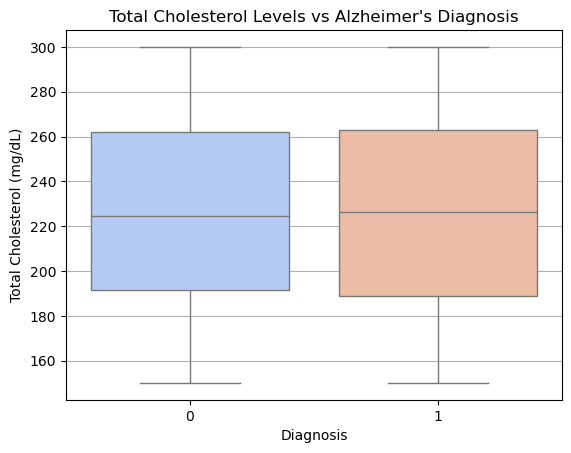

In [20]:
# Does cholestrol impact risk of ALzheimer's?
sns.boxplot(data=data, x='Diagnosis', y='CholesterolTotal', palette='coolwarm')
plt.title('Total Cholesterol Levels vs Alzheimer\'s Diagnosis')
plt.xlabel('Diagnosis')
plt.ylabel('Total Cholesterol (mg/dL)')
plt.grid(axis='y')
plt.show()


/tmp/ipykernel_2468935/341086383.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='Diagnosis', y='CholesterolHDL', palette='coolwarm')


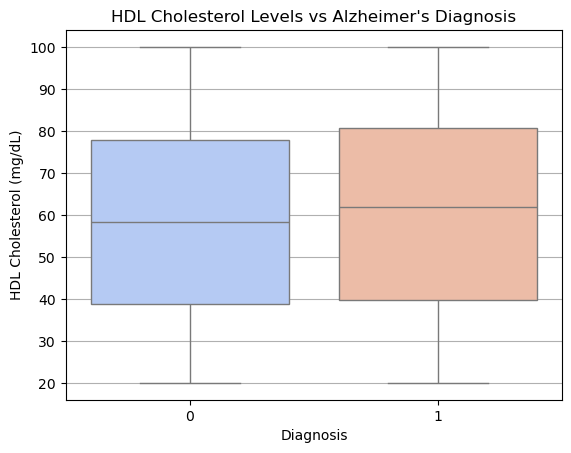

In [21]:
# Does CholestrolHDL decrease risk of ALzheimer's?
sns.boxplot(data=data, x='Diagnosis', y='CholesterolHDL', palette='coolwarm')
plt.title('HDL Cholesterol Levels vs Alzheimer\'s Diagnosis')
plt.xlabel('Diagnosis')
plt.ylabel('HDL Cholesterol (mg/dL)')
plt.grid(axis='y')
plt.show()


/tmp/ipykernel_2468935/439105723.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=proportion_data, x='FamilyHistoryAlzheimers', y='Diagnosis', palette='coolwarm')


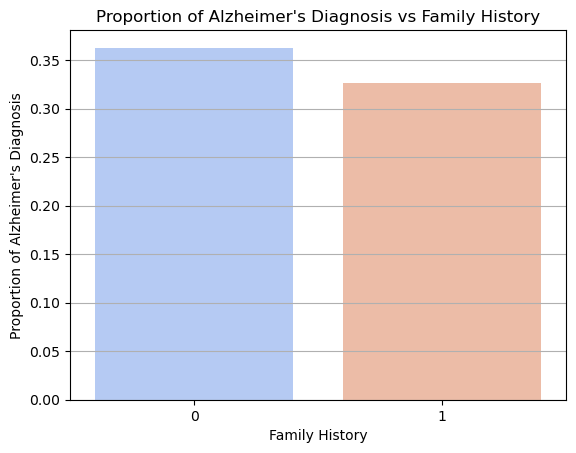

In [22]:
# Is family history a strong indicator of Alzheimer's?
proportion_data = data.groupby('FamilyHistoryAlzheimers')['Diagnosis'].mean().reset_index()
sns.barplot(data=proportion_data, x='FamilyHistoryAlzheimers', y='Diagnosis', palette='coolwarm')
plt.title('Proportion of Alzheimer\'s Diagnosis vs Family History')
plt.xlabel('Family History')
plt.ylabel('Proportion of Alzheimer\'s Diagnosis')
plt.grid(axis='y')
plt.show()


In [ ]:
# Which assessment is the best for predicting a Alzheimer's Diagnosis?
melted_data = data.melt(id_vars='Diagnosis', value_vars=['MMSE', 'FunctionalAssessment', 'ADL'], 
                        var_name='Metric', value_name='Score')
plt.figure(figsize=(10, 10))
sns.violinplot(data=melted_data, x='Metric', y='Score', hue='Diagnosis', split=True, palette='coolwarm')
plt.title('Distribution of MMSE, Functional Assessment, and ADL vs Alzheimer\'s Diagnosis')
plt.xlabel('Assessment')
plt.ylabel('Score')
plt.legend(title='Diagnosis', labels=['No', 'Yes'])
plt.grid(axis='y')
plt.show()


In [ ]:
# When present, how do these factors affect the likelihood of an Alzheimer's diagnosis?
factors = [
    'FamilyHistoryAlzheimers', 'CardiovascularDisease', 'Diabetes', 'Depression',
    'HeadInjury', 'Hypertension', 'MemoryComplaints', 'BehavioralProblems',
    'Confusion', 'Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks', 'Forgetfulness', "Smoking"
]
melted_data = data.melt(id_vars='Diagnosis', value_vars=factors, 
                        var_name='Factor', value_name='Presence')
filtered_data = melted_data[melted_data['Presence'] == 1]
grouped_data = filtered_data.groupby(['Factor', 'Diagnosis']).size().reset_index(name='Count')
pivot_data = grouped_data.pivot_table(index='Factor', columns='Diagnosis', values='Count', fill_value=0)
pivot_data.plot(kind='bar', stacked=True, figsize=(12, 12), color=['blue', 'red'])
plt.title('Impact of Factors (When Present) on Alzheimer\'s Diagnosis')
plt.xlabel('Factors')
plt.ylabel('Number of Patients')
plt.legend(title='Diagnosis', labels=['No', 'Yes'])
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [25]:
# What are the top 3 health conditions that have the highest Alzheimer's Diagnosis?
selected_factors = ['Smoking', 'Diabetes', 'Depression', 'CardiovascularDisease']
alzheimers_factors = data[data['Diagnosis'] == 1]
factor_counts = alzheimers_factors[selected_factors].sum().reset_index()
factor_counts.columns = ['Factor', 'Count']
top_factors_selected = factor_counts.sort_values(by='Count', ascending=False).head(3)
top_factors_selected.index = range(1, len(top_factors_selected) + 1)
top_factors_selected


,Factor,Count
1,Smoking,217
2,Depression,150
3,CardiovascularDisease,121


In [26]:
# What are the top 3 symptoms that have the highest Alzheimer's Diagnosis?
alzheimers_data = filtered_data[filtered_data['Diagnosis'] == 1].groupby('Factor')['Diagnosis'].count().reset_index(name='Count')
top_factors = alzheimers_data.sort_values(by='Count', ascending=False).head(3)
top_factors.index = range(1, len(top_factors) + 1)
top_factors

,Factor,Count
1,MemoryComplaints,286
2,Forgetfulness,229
3,Smoking,217
